## CMIP6 sea ice thickness bias

## Import libraries

In [1]:
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot

plt.style.use("seaborn-v0_8-notebook")
warnings.filterwarnings("ignore", module="cf_xarray")

## Set parameters

In [2]:
year_start = 2002
year_stop = 2014
assert year_start >= 2002 and year_stop <= 2014

# Choose CMIP6 historical models
models = [
    "access_cm2",
    "access_esm1_5",
    "canesm5",
    "cmcc_cm2_sr5",
    "cmcc_esm2",
    "cnrm_cm6_1",
    "cnrm_cm6_1_hr",
    "cnrm_esm2_1",
    "e3sm_1_0",
    "e3sm_1_1",
    "e3sm_1_1_eca",
    "ec_earth3_aerchem",
    "ec_earth3_cc",
    "ec_earth3_veg_lr",
    "hadgem3_gc31_ll",
    "ipsl_cm5a2_inca",
    "ipsl_cm6a_lr",
    "miroc6",
    "miroc_es2l",
    "mpi_esm1_2_hr",
    "mpi_esm1_2_lr",
    "nesm3",
    "norcpm1",
    # "taiesm1",  # very large values
    "ukesm1_0_ll",
]

## Define request

In [3]:
months = [f"{month:02d}" for month in [1, 2, 3, 4, 10, 11, 12]]
year_ranges = {
    "envisat": range(max(2002, year_start), min(2010, year_stop) + 1),
    "cryosat_2": range(max(2010, year_start), min(2020, year_stop) + 1),
}
collection_id_satellite = "satellite-sea-ice-thickness"
request_satellite = {
    "version": "2_0",
    "cdr_type": "cdr",
    "variable": "all",
    "month": months,
}

collection_id_cmip6 = "projections-cmip6"
request_cmip6 = {
    "format": "zip",
    "temporal_resolution": "monthly",
    "experiment": "historical",
    "variable": "sea_ice_thickness",
    "month": months,
}

chunks = {"year": 1}

## Define function to cache

In [4]:
def regridded_time_weighted_mean(ds, times, **kwargs):
    ds_sat = download.download_and_transform(
        "satellite-sea-ice-thickness",
        {
            "satellite": "envisat",
            "version": "2_0",
            "cdr_type": "cdr",
            "variable": "all",
            "year": "2002",
            "month": [f"{month:02d}" for month in [1, 2, 3, 4, 10, 11, 12]],
        },
        chunks={"year": 1},
    )
    ds["time"] = pd.to_datetime(ds["time"].dt.strftime("%Y-%m"))
    ds["time"].attrs["standard_name"] = "time"
    ds = ds.sel(time=times)
    ds = diagnostics.time_weighted_mean(ds)
    return diagnostics.regrid(ds, ds_sat[["latitude", "longitude"]], **kwargs)

## Download and transform

In [5]:
datasets_satellites = []
datasets_cmip6 = []
for satellite, year_range in year_ranges.items():
    print(f"{satellite=}")
    years = list(map(str, year_range))
    ds = download.download_and_transform(
        collection_id_satellite,
        request_satellite | {"satellite": satellite, "year": years},
        chunks=chunks,
    )
    times = ds["time"].dt.strftime("%Y-%m").values.tolist()
    ds = diagnostics.time_weighted_mean(ds)
    datasets_satellites.append(
        ds.expand_dims(satellite=[satellite], product=["satellite"])
    )

    model_datasets = []
    for model in models:
        print(f"{satellite=} {model=}")
        ds = download.download_and_transform(
            collection_id_cmip6,
            request_cmip6 | {"model": model, "year": years},
            chunks=chunks,
            transform_chunks=False,
            transform_func=regridded_time_weighted_mean,
            transform_func_kwargs={
                "times": times,
                "method": "nearest_s2d",
                "periodic": True,
                "ignore_degenerate": True,
            },
        )
        model_datasets.append(
            ds.expand_dims(model=[model], satellite=[satellite], product=["cmip6"])
        )
    datasets_cmip6.append(
        xr.concat(model_datasets, "model").mean("model", keep_attrs=True)
    )
ds_satellites = xr.concat(datasets_satellites, "satellite")
ds_cmip6 = xr.concat(datasets_cmip6, "satellite")

satellite='envisat'


100%|██████████| 9/9 [00:01<00:00,  5.05it/s]


satellite='envisat' model='access_cm2'
satellite='envisat' model='access_esm1_5'
satellite='envisat' model='canesm5'
satellite='envisat' model='cmcc_cm2_sr5'
satellite='envisat' model='cmcc_esm2'
satellite='envisat' model='cnrm_cm6_1'
satellite='envisat' model='cnrm_cm6_1_hr'
satellite='envisat' model='cnrm_esm2_1'
satellite='envisat' model='e3sm_1_0'
satellite='envisat' model='e3sm_1_1'
satellite='envisat' model='e3sm_1_1_eca'
satellite='envisat' model='ec_earth3_aerchem'
satellite='envisat' model='ec_earth3_cc'
satellite='envisat' model='ec_earth3_veg_lr'
satellite='envisat' model='hadgem3_gc31_ll'
satellite='envisat' model='ipsl_cm5a2_inca'
satellite='envisat' model='ipsl_cm6a_lr'
satellite='envisat' model='miroc6'
satellite='envisat' model='miroc_es2l'
satellite='envisat' model='mpi_esm1_2_hr'
satellite='envisat' model='mpi_esm1_2_lr'
satellite='envisat' model='nesm3'
satellite='envisat' model='norcpm1'
satellite='envisat' model='ukesm1_0_ll'
satellite='cryosat_2'


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


satellite='cryosat_2' model='access_cm2'
satellite='cryosat_2' model='access_esm1_5'
satellite='cryosat_2' model='canesm5'
satellite='cryosat_2' model='cmcc_cm2_sr5'
satellite='cryosat_2' model='cmcc_esm2'
satellite='cryosat_2' model='cnrm_cm6_1'
satellite='cryosat_2' model='cnrm_cm6_1_hr'
satellite='cryosat_2' model='cnrm_esm2_1'
satellite='cryosat_2' model='e3sm_1_0'
satellite='cryosat_2' model='e3sm_1_1'
satellite='cryosat_2' model='e3sm_1_1_eca'
satellite='cryosat_2' model='ec_earth3_aerchem'
satellite='cryosat_2' model='ec_earth3_cc'
satellite='cryosat_2' model='ec_earth3_veg_lr'
satellite='cryosat_2' model='hadgem3_gc31_ll'
satellite='cryosat_2' model='ipsl_cm5a2_inca'
satellite='cryosat_2' model='ipsl_cm6a_lr'
satellite='cryosat_2' model='miroc6'
satellite='cryosat_2' model='miroc_es2l'
satellite='cryosat_2' model='mpi_esm1_2_hr'
satellite='cryosat_2' model='mpi_esm1_2_lr'
satellite='cryosat_2' model='nesm3'
satellite='cryosat_2' model='norcpm1'
satellite='cryosat_2' model='ukes

## Plot maps

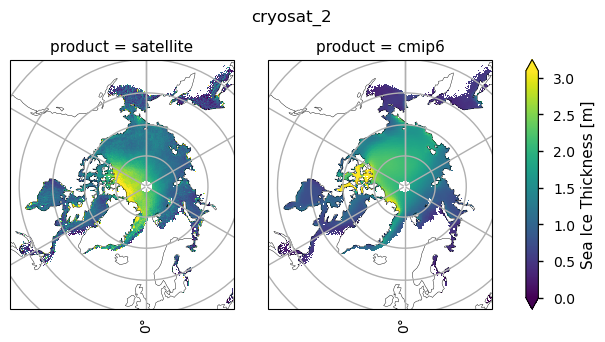

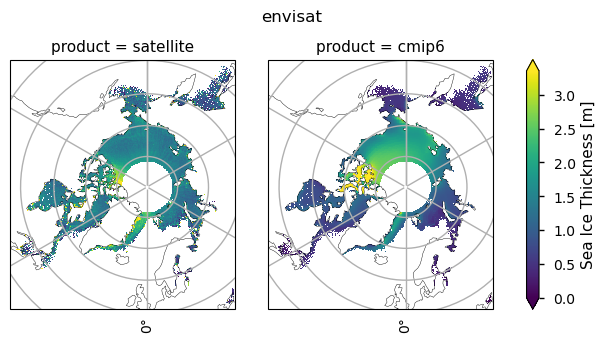

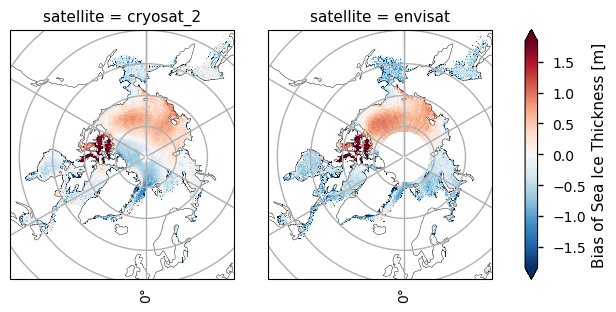

In [10]:
projection = ccrs.Stereographic(central_latitude=90)

biases = []
for satellite, ds_satellite in ds_satellites.groupby("satellite"):
    da_satellite = ds_satellite["sea_ice_thickness"]
    mask = da_satellite.squeeze("product", drop=True).notnull()
    da_cmip6 = ds_cmip6.sel(satellite=[satellite])["sithick"]
    da = xr.concat([da_satellite, da_cmip6], "product")
    da = da.where(mask.compute(), drop=True)
    facet = plot.projected_map(
        da, col="product", vmin=0, robust=True, projection=projection
    )
    facet.fig.suptitle(satellite, y=1.05)

    with xr.set_options(keep_attrs=True):
        bias = da_cmip6.squeeze("product") - da_satellite.squeeze("product")
    bias.attrs["long_name"] = "Bias of " + bias.attrs["long_name"]
    biases.append(bias)

bias = xr.concat(biases, "satellite")
for dim in bias.dims:
    bias = bias.dropna(dim, how="all")
plot.projected_map(bias, col="satellite", projection=projection, robust=True)